In [10]:
#pip install numpy
#pip install pandas
#pip install matplotlib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt

In [11]:
input_path = 'D:/Downloads/ej_redes/tgs-salt-identification-challenge/competition_data/competition_data/'
train_path = input_path + 'train'
test_path = input_path + 'test'

train_df = pd.read_csv(input_path + 'train.csv')

In [12]:
from PIL import Image
#pip install image-dataset-viz
from image_dataset_viz import render_datapoint

In [5]:
import os
import zipfile

Dataset = train_path

train_path = './train_path'
if not os.path.exists(train_path):
    os.mkdir(train_path)

with zipfile.ZipFile(Dataset+".zip","r") as z:
    z.extractall(train_path)
    
Dataset = test_path

test_path = './test_path'
if not os.path.exists(test_path):
    os.mkdir(test_path)

with zipfile.ZipFile(Dataset+".zip","r") as z:
    z.extractall(test_path)

In [13]:
image='0a0814464f'
def read_image(data_id, is_train=True):    
    path = train_path if is_train else test_path
    path = (path + "/images" + "/{}.png".format(data_id))
    img = Image.open(path)
    img = img.convert('RGB')
    return img
    
def read_mask(data_id, is_train=True):
    path = train_path if is_train else test_path
    path = (path + "/masks" + "/{}.png".format(data_id))    
    img = Image.open(path)
    bk = Image.new('L', size=img.size)
    g = Image.merge('RGB', (bk, img.convert('L'), bk))
    return g

(101, 101)


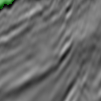

In [14]:
img = read_image(image)
mask = read_mask(image)
rimg = render_datapoint(img, mask, blend_alpha=0.3)
print(rimg.size)
rimg

In [15]:
#export dataset to few images to easily visualize them
data_ids = train_df['id'].values.tolist()


from image_dataset_viz import DatasetExporter


de = DatasetExporter(read_image, read_mask, blend_alpha=0.3, n_cols=20, max_output_img_size=(100, 100))
de.export(data_ids, data_ids, "train_dataset_viz")

100%|##########|4000/4000[00:26<00:00,153.09it/s]


## Implementación de U-NET

In [16]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
#plt.style.use('seaborn-whimport seaborn as sns ie's
#pip install seaborn
import seaborn as sns
sns.set_style("white")

#pip install sklearn
#pip install tensorflow
#pip install scikit-image

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from tensorflow.keras.layers import Conv2D, Concatenate, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook


In [17]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', anti_aliasing=True,preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant',anti_aliasing=True, preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

## Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [19]:
input_path = 'D:/Downloads/ej_redes/tgs-salt-identification-challenge/competition_data/competition_data/'

train_df = pd.read_csv(input_path + 'train.csv', index_col='id', usecols=[0])
depths_df = pd.read_csv(input_path + 'depths.csv', index_col='id')
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]
train_df.reset_index()
test_df.reset_index()
train_df.head(10)

,z
id,
2c45b152f1,312
3cb59a4fdc,603
e185ab5dc1,687
c78c89577c,236
6306dd3a8e,805
aae8971d6e,231
b80db32c01,704
164873b51f,162
e335542c17,505


In [20]:
test_df.head()

,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


In [21]:
img_path = train_path + "/images/{}.png"
train_df["images"] = [(np.array(load_img(img_path.format(idx), color_mode = "grayscale"))+20*np.random.normal(size=[101,101])) / 255 for idx in train_df.index]

In [22]:
img_path = train_path + "/masks/{}.png"
train_df["masks"] = [np.array(load_img(img_path.format(idx), color_mode = "grayscale")) / 255 for idx in train_df.index]

## Calculating the salt coverage and salt coverage classes

Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [23]:
train_df["coverage"] = train_df.masks.map(np.sum) / (pow(img_size_ori, 2)*257)

In [24]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
 
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)



0.5309283403587883


In [25]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
2c45b152f1,312,"[[0.3754818234506211, 0.3369543466001943, 0.23...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.530928,6
3cb59a4fdc,603,"[[0.4264894848508857, 0.5333139906291662, 0.53...","[[257.0, 257.0, 257.0, 257.0, 257.0, 257.0, 25...",0.554455,6
e185ab5dc1,687,"[[0.5180777794043788, 0.6384059283071954, 0.51...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.481717,5
c78c89577c,236,"[[0.19543395186500134, 0.27244420396064306, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000098,1
6306dd3a8e,805,"[[0.5039163296812456, 0.5995932297020038, 0.63...","[[257.0, 257.0, 257.0, 257.0, 257.0, 257.0, 25...",0.078718,1


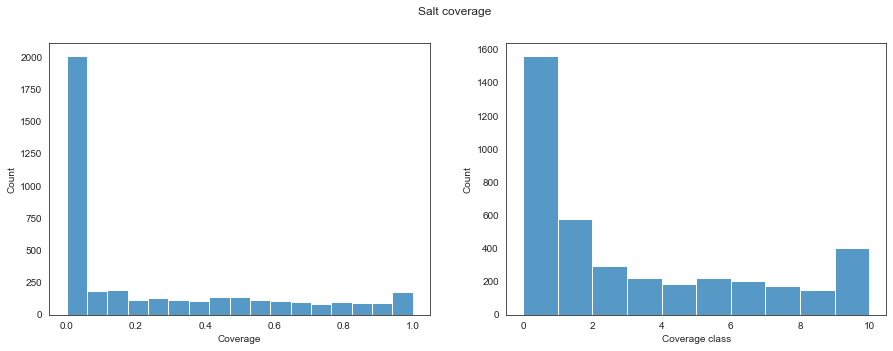

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(train_df.coverage, kde=False, ax=axs[0])
sns.histplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
plt.show()

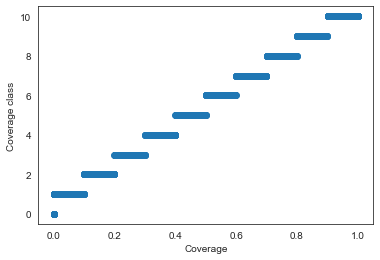

In [27]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")
plt.show()

## Plotting the depth distributions

Separatelty plotting the depth distributions for the training and the testing data.

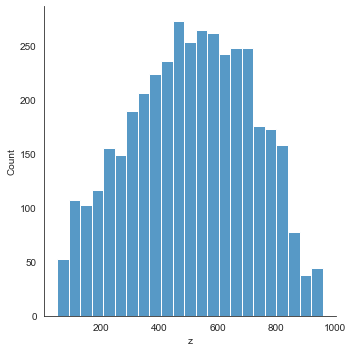

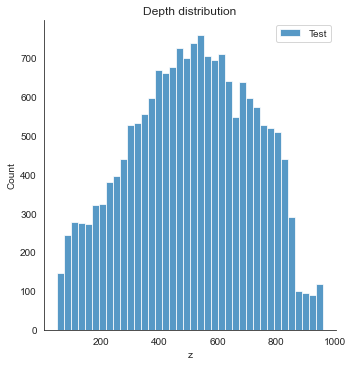

In [28]:
sns.displot(train_df.z, label="Train")
sns.displot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")
plt.show()

## Show some example images

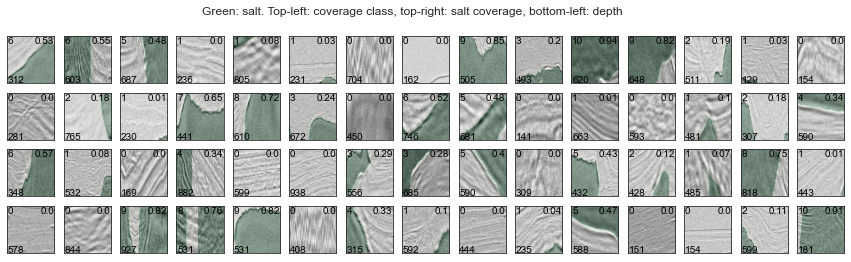

In [29]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
plt.show()

## Create train/validation split stratified by salt coverage

Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [30]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [31]:
x_train.shape

(3200, 128, 128, 1)

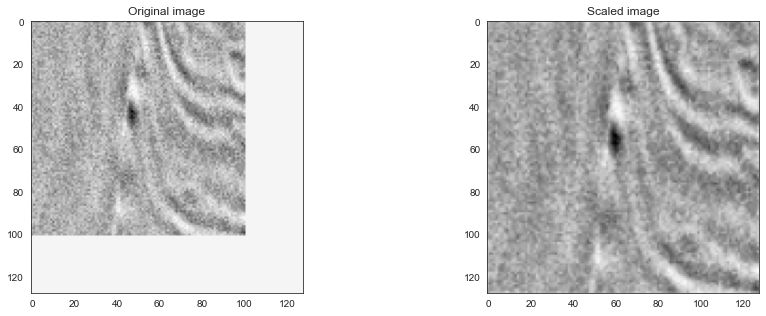

In [32]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")
plt.show()

## Build Model

In [33]:
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [34]:
model = UNet((img_size_target,img_size_target,1),start_ch=32,depth=5,batchnorm=True)

In [35]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Data Augmentation

In [36]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

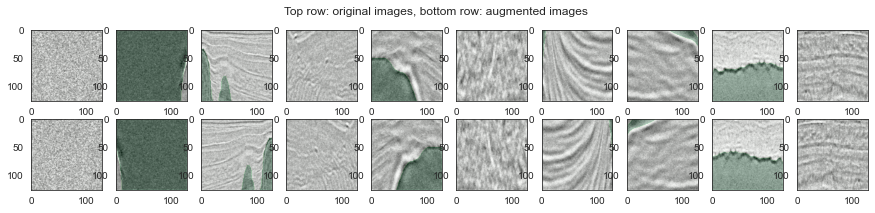

In [37]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")
plt.show()

## Training

In [38]:
import keras.backend as K
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

def iou_coef(y_true, y_pred, smooth=1):
#    """
#    IoU = (|X & Y|)/ (|X or Y|)
#    """
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum((y_true) + K.sum(y_pred)) - intersection
    return ((intersection + smooth)/(union + smooth))

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)
                  
model.compile(loss='mse', optimizer="nadam", metrics=["accuracy"])
epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid), 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],shuffle=True)

Epoch 1/200
 96/200 [=============>................] - ETA: 12:45 - loss: 16041.3818 - accuracy: 0.2106

KeyboardInterrupt: 

In [32]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax_acc.legend()
plt.show()

In [40]:
model = load_model("./keras.model")

## Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

25/25 [==============================] - 33s 1s/step


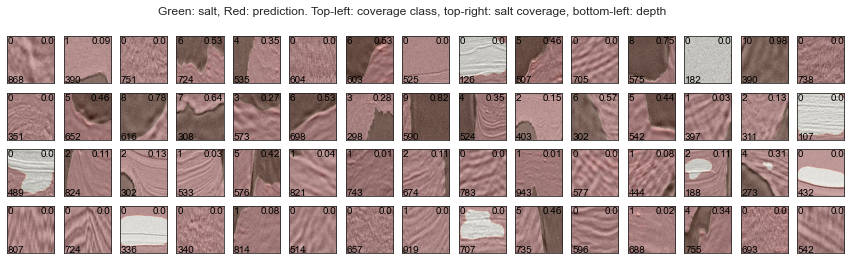

In [41]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
plt.show()

## Scoring
Score the model and do a threshold optimization by the best IoU.

In [42]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [43]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in thresholds])
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

[]

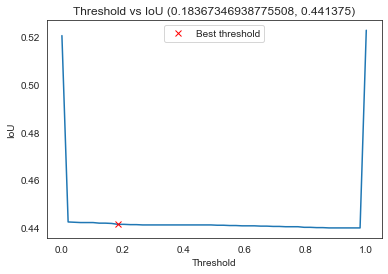

In [44]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()
plt.plot()

## Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

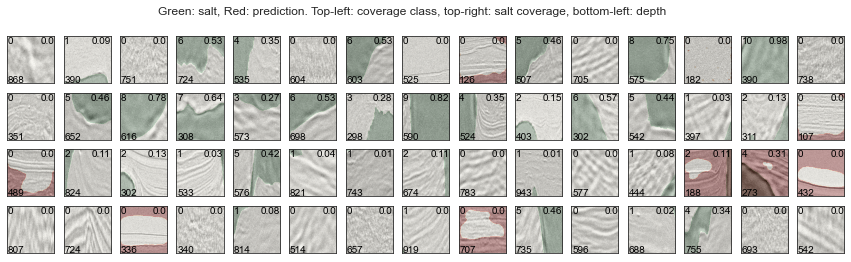

In [45]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
plt.show()

## Submission
Load, predict and submit the test image predictions.

In [46]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [48]:
img_path = test_path + "/images/{}.png"
x_test = np.array([upsample(np.array(load_img(img_path.format(idx), color_mode = "grayscale"))) / 255 for idx in test_df.index]).reshape(-1, img_size_target, img_size_target, 1)


In [49]:
preds_test = model.predict(x_test)
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(test_df.index.values)}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

563/563 [==============================] - 978s 2s/step
